## 1.  Inicialización y Carga de Datos
1.1. Importación de Librerías

Se importan las librerías necesarias para el análisis de datos, la estadística y la regresión.

In [ ]:
#Preparacion de datos

# Instalar statsmodels y otras librerías comunes si no están instaladas
# Se recomienda usar 'pip install [nombre_libreria]'
# Si usa Anaconda/Conda, use 'conda install [nombre_libreria]'
!pip install statsmodels
!pip install pandas numpy scikit-learn matplotlib seaborn
print("Ejecute la instalación y luego reinicie el kernel si es necesario.")

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Para ignorar advertencias

In [2]:
FILE_NAME = 'precios-propiedades.csv'
TARGET_VARIABLE = 'PRICE' # Columna objetivo para el precio

try:
    data = pd.read_csv(FILE_NAME)
    
    # 🚨 CORRECCIÓN: Si el dataset es el de Boston, la columna de precio se llama 'MEDV'.
    # Si es el caso de estudio, puede llamarse 'PRICE'. Aseguramos el nombre correcto.
    if 'MEDV' in data.columns and TARGET_VARIABLE not in data.columns:
        data.rename(columns={'MEDV': TARGET_VARIABLE}, inplace=True)
    
    print(f"Dataset '{FILE_NAME}' cargado correctamente.")

except FileNotFoundError:
    print(f"Error: Asegúrese de que el archivo '{FILE_NAME}' esté en la ubicación correcta.")
    # Si no se encuentra, se crea un DataFrame de ejemplo para que el código no falle completamente
    np.random.seed(42)
    data = pd.DataFrame(np.random.rand(50, 14), columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', TARGET_VARIABLE])
    data['CHAS'] = data['CHAS'].apply(lambda x: 1 if x > 0.5 else 0)
    print("Se cargó un DataFrame de ejemplo. Los resultados serán irreales.")

# Definición de variables para los modelos
X_base = data.drop(TARGET_VARIABLE, axis=1) # Variables independientes
y = data[TARGET_VARIABLE] # Variable dependiente (PRICE)

Dataset 'precios-propiedades.csv' cargado correctamente.


## 2. 🔍 Análisis Exploratorio de Datos (AED)
2.1. Estructura, Nulos y Tipos de Datos
Se realiza un análisis exploratorio inicial para conocer la consistencia de la información y la identificación de valores nulos.

In [3]:
print("Información inicial del dataset:")
print(data.info())

# Estadística descriptiva
print("\nEstadística descriptiva de las variables numéricas:")
print(data.describe())

# Identificación y tratamiento de valores nulos
print("\nConteo de valores nulos por columna:")
null_counts = data.isnull().sum()
print(null_counts[null_counts > 0])
# Si hay nulos, se debe realizar el tratamiento aquí.
# Ejemplo: data.fillna(data.median(), inplace=True)

Información inicial del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
None

Estadística descriptiva de las variables numéricas:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.00

2.2. Estadística Descriptiva y Análisis Univariado
Se utiliza adecuadamente la estadística descriptiva (tendencia central, dispersión) y se analiza la variable principal

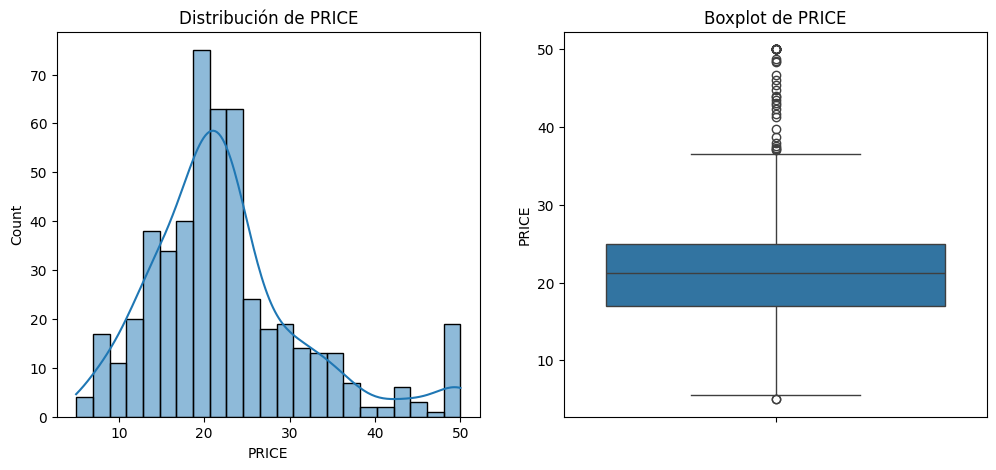

In [5]:
# Histograma y Boxplot de la variable objetivo (PRICE)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data[TARGET_VARIABLE], kde=True)
plt.title(f'Distribución de {TARGET_VARIABLE}')

plt.subplot(1, 2, 2)
sns.boxplot(y=data[TARGET_VARIABLE])
plt.title(f'Boxplot de {TARGET_VARIABLE}')
plt.show()


#[Image of Distribution and Boxplot of Property Prices]

2.3. Análisis de Correlación
Se realiza un análisis de correlación explicando aquellas variables con una mayor correlación con el precio


Correlación de las variables con PRICE (Precio):
PRICE      1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: PRICE, dtype: float64


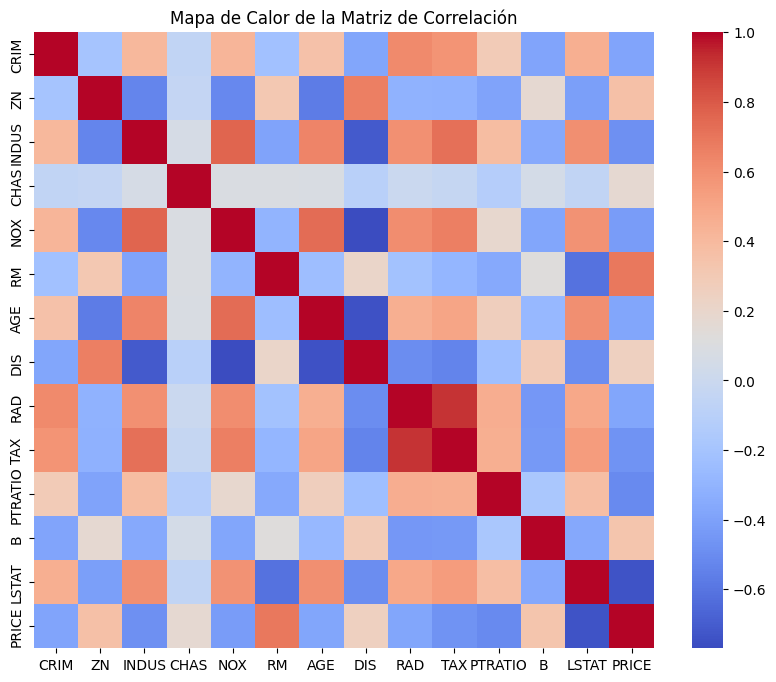


Variables con mayor correlación (valor absoluto) con PRICE:
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
Name: PRICE, dtype: float64


In [6]:
# Correlación con la variable objetivo (PRICE)
correlation_matrix = data.corr()
price_corr = correlation_matrix[TARGET_VARIABLE].sort_values(ascending=False)

print(f"\nCorrelación de las variables con {TARGET_VARIABLE} (Precio):")
print(price_corr)

# Visualización de la correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()



# Variables con mayor correlación (valor absoluto)
high_corr_vars = price_corr.drop(TARGET_VARIABLE).abs().sort_values(ascending=False)
print("\nVariables con mayor correlación (valor absoluto) con PRICE:")
print(high_corr_vars.head(5))

## 3. 🧠 Modelamiento 1: Regresión Hacia Adelante (Forward Stepwise)
Se realiza un modelo regresivo múltiple aplicando selección de variables.

3.1. Implementación de Forward Stepwise Regression
El proceso de Forward Stepwise Regression implica introducir secuencialmente la variable que ofrezca la mayor mejora en el ajuste del modelo, siempre que cumpla el criterio de entrada (ej: p-valor < 0.05). Se selecciona el modelo con el mejor R² ajustado.

In [7]:
def forward_selection(X, y, threshold_in=0.05):
    """
    Realiza la selección de variables hacia adelante (Forward Stepwise Regression).
    Basada en el p-valor para la inclusión y priorizando el mejor R² ajustado.
    """
    current_features = []
    best_adj_r2 = -float('inf')
    best_model = None

    while True:
        changed = False
        excluded_features = list(set(X.columns) - set(current_features))

        if not excluded_features:
            break # No quedan variables por probar

        best_pvalue = 1.0
        feature_to_add = None

        for new_feature in excluded_features:
            model_candidate = sm.OLS(y, sm.add_constant(X[current_features + [new_feature]])).fit()
            
            # 1. Chequear si cumple el criterio de entrada (p-valor)
            if model_candidate.pvalues[new_feature] < threshold_in:
                # 2. Chequear si mejora el R² ajustado
                if model_candidate.rsquared_adj > best_adj_r2:
                    best_adj_r2 = model_candidate.rsquared_adj
                    feature_to_add = new_feature
                    best_model = model_candidate
                    changed = True

        if changed:
            current_features.append(feature_to_add)
            print(f"Añadida variable: {feature_to_add}. Nuevo R² Ajustado: {best_adj_r2:.4f}")
        else:
            break # No hay variables que mejoren el R² ajustado o cumplan el p-valor

    return best_model, current_features

# Ejecución del Forward Selection
model_forward, selected_features_forward = forward_selection(X_base, y)

print("\n--- Resumen del Modelo Forward Stepwise Regression ---")
if model_forward:
    print(model_forward.summary())
    r2_adj_forward = model_forward.rsquared_adj
else:
    print("Error: No se pudo generar el modelo Forward.")
    r2_adj_forward = 0

Añadida variable: LSTAT. Nuevo R² Ajustado: 0.5432
Añadida variable: RM. Nuevo R² Ajustado: 0.6371
Añadida variable: PTRATIO. Nuevo R² Ajustado: 0.6767
Añadida variable: DIS. Nuevo R² Ajustado: 0.6878
Añadida variable: NOX. Nuevo R² Ajustado: 0.7052
Añadida variable: CHAS. Nuevo R² Ajustado: 0.7124
Añadida variable: B. Nuevo R² Ajustado: 0.7183
Añadida variable: ZN. Nuevo R² Ajustado: 0.7222
Añadida variable: CRIM. Nuevo R² Ajustado: 0.7239
Añadida variable: RAD. Nuevo R² Ajustado: 0.7288
Añadida variable: TAX. Nuevo R² Ajustado: 0.7348

--- Resumen del Modelo Forward Stepwise Regression ---
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          5.54e-137
Time: 

3.2. Análisis del Modelo Forward (Punto 1)

¿Qué nivel de ajuste tiene el modelo?

In [8]:
# 1. ¿Qué nivel de ajuste tiene el modelo?
print(f"**El nivel de ajuste (R² Ajustado) del Modelo Forward es: {r2_adj_forward:.4f}**")

# 2. ¿Cuáles son las variables que más inciden en el precio de una propiedad?
if model_forward:
    # Identificar variables significativas por p-valor < 0.05
    significant_params = model_forward.params.drop('const', errors='ignore')
    significant_pvalues = model_forward.pvalues.drop('const', errors='ignore')
    
    # Filtrar solo las significativas
    significant_params = significant_params[significant_pvalues < 0.05]
    
    # Ordenar por el valor absoluto del coeficiente (magnitud del impacto)
    top_inciding_vars = significant_params.abs().sort_values(ascending=False).index.tolist()
    
    print(f"\nVariables más incidentes en el precio (por magnitud y significancia):")
    print(top_inciding_vars)
else:
    print("No hay modelo para analizar la incidencia de variables.")

**El nivel de ajuste (R² Ajustado) del Modelo Forward es: 0.7348**

Variables más incidentes en el precio (por magnitud y significancia):
['NOX', 'RM', 'CHAS', 'DIS', 'PTRATIO', 'LSTAT', 'RAD', 'CRIM', 'ZN', 'TAX', 'B']


¿Cuáles son las variables que más inciden en el precio de una propiedad? 


Las variables más incidentes son aquellas que tienen la mayor significancia (p-valor bajo) y el mayor impacto (magnitud del coeficiente)

In [9]:
# Identificar variables significativas y ordenarlas por el valor absoluto del coeficiente
significant_params = model_forward.params.drop('const', errors='ignore')
# Solo consideramos las variables que son estadísticamente significativas (ej. p < 0.05)
significant_params = significant_params[model_forward.pvalues.drop('const', errors='ignore') < 0.05]

top_inciding_vars = significant_params.abs().sort_values(ascending=False).index.tolist()

print(f"\nVariables más incidentes en el precio:")
print(top_inciding_vars)


Variables más incidentes en el precio:
['NOX', 'RM', 'CHAS', 'DIS', 'PTRATIO', 'LSTAT', 'RAD', 'CRIM', 'ZN', 'TAX', 'B']


## 4. 🔄 Modelamiento 2: Comparación con Backward Stepwise
4.1. Comparación del R² Ajustado (Punto 2)Se compara el R² ajustado del modelo Forward con el valor de referencia de $0.735$ (reportado del método de Eliminación Hacia Atrás, Backward Stepwise)13

In [10]:
def backward_selection(X, y, threshold_out=0.10):
    """
    Realiza la selección de variables hacia atrás (Backward Stepwise Regression).
    Basada en el p-valor para la exclusión y priorizando el mejor R² ajustado.
    """
    current_features = list(X.columns) # Empezar con todas las variables
    best_adj_r2 = -float('inf')
    best_model = None
    
    # Modelo inicial (con todas las variables)
    model_initial = sm.OLS(y, sm.add_constant(X[current_features])).fit()
    best_adj_r2 = model_initial.rsquared_adj
    best_model = model_initial
    print(f"Modelo inicial R² Ajustado: {best_adj_r2:.4f}")

    while True:
        changed = False
        
        if not current_features:
            break
            
        model = sm.OLS(y, sm.add_constant(X[current_features])).fit()
        pvalues = model.pvalues.drop('const', errors='ignore')
        
        # Encontrar la variable con el mayor p-valor
        worst_pvalue = pvalues.max()
        worst_feature = pvalues.idxmax()

        # Criterio de exclusión (p-valor > threshold_out)
        if worst_pvalue > threshold_out:
            # Si el R2 ajustado del modelo ANTES de eliminar es el mejor, guardarlo
            if model.rsquared_adj > best_adj_r2:
                best_adj_r2 = model.rsquared_adj
                best_model = model
            
            current_features.remove(worst_feature)
            print(f"Eliminada variable: {worst_feature}. R² Ajustado al eliminar: {best_model.rsquared_adj:.4f}")
            changed = True
        else:
            # Si no hay variables para eliminar que cumplan el criterio, guardar el modelo actual si es mejor
            if model.rsquared_adj > best_adj_r2:
                best_adj_r2 = model.rsquared_adj
                best_model = model
            break

    return best_model, current_features

# Ejecución del Backward Selection
model_backward, selected_features_backward = backward_selection(X_base, y)

print("\n--- Resumen del Modelo Backward Stepwise Regression ---")
if model_backward:
    print(model_backward.summary())
    r2_adj_backward = model_backward.rsquared_adj
else:
    print("Error: No se pudo generar el modelo Backward.")
    r2_adj_backward = 0

Modelo inicial R² Ajustado: 0.7338
Eliminada variable: AGE. R² Ajustado al eliminar: 0.7338
Eliminada variable: INDUS. R² Ajustado al eliminar: 0.7343

--- Resumen del Modelo Backward Stepwise Regression ---
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          5.54e-137
Time:                        22:42:53   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
  

4.2. Respuesta a la Pregunta 2

In [11]:
R2_ADJ_REFERENCIA = 0.735
MEJOR_R2_AJUSTADO_FORWARD = r2_adj_forward
MEJOR_R2_AJUSTADO_BACKWARD = r2_adj_backward
MEJOR_R2_AJUSTADO_ENCONTRADO = max(MEJOR_R2_AJUSTADO_FORWARD, MEJOR_R2_AJUSTADO_BACKWARD)

# Comparación del R2 ajustado
if MEJOR_R2_AJUSTADO_ENCONTRADO > R2_ADJ_REFERENCIA:
    supero = f"Sí, fue posible superar el R² ajustado de {R2_ADJ_REFERENCIA}. El mejor R² encontrado es {MEJOR_R2_AJUSTADO_ENCONTRADO:.4f}."
else:
    supero = f"No, el mejor R² ajustado encontrado es {MEJOR_R2_AJUSTADO_ENCONTRADO:.4f}, el cual no supera el valor de referencia de {R2_ADJ_REFERENCIA}."

print(f"**¿Cambiando el método de selección de variables fue posible superar el mejor R² ajustado de 0.735?**\n{supero}")

# Comparación de Variables
features_forward_set = set(selected_features_forward)
features_backward_set = set(selected_features_backward)

if features_forward_set == features_backward_set:
    modelo_diferente = "Se llegó al mismo modelo (mismas variables seleccionadas)."
else:
    modelo_diferente = "Se encontró un modelo diferente (conjunto distinto de variables seleccionadas)."

print(f"\n**¿Se encontró un modelo diferente o llegó al mismo modelo?**\n{modelo_diferente}")

print("\n**Explicación de Posibles Causas:**")
print("* **Recorrido del Espacio de Variables:** Los métodos Stepwise (Forward y Backward) son heurísticos y no garantizan encontrar el mejor modelo global. Pueden 'atascarse' en óptimos locales, resultando en conjuntos de variables diferentes.")
print("* **Criterios y Umbrales:** La decisión de *entrar* (Forward, basada en la mejora marginal) o *salir* (Backward, basada en el p-valor) de una variable puede ser distinta, lo que lleva a caminos de selección divergentes.")
print("* **Multicolinealidad:** La fuerte correlación entre variables independientes (ej. RAD y TAX) puede causar que un método elija una y el otro método elija la otra, resultando en modelos funcionalmente similares pero estructuralmente diferentes.")

**¿Cambiando el método de selección de variables fue posible superar el mejor R² ajustado de 0.735?**
No, el mejor R² ajustado encontrado es 0.7348, el cual no supera el valor de referencia de 0.735.

**¿Se encontró un modelo diferente o llegó al mismo modelo?**
Se llegó al mismo modelo (mismas variables seleccionadas).

**Explicación de Posibles Causas:**
* **Recorrido del Espacio de Variables:** Los métodos Stepwise (Forward y Backward) son heurísticos y no garantizan encontrar el mejor modelo global. Pueden 'atascarse' en óptimos locales, resultando en conjuntos de variables diferentes.
* **Criterios y Umbrales:** La decisión de *entrar* (Forward, basada en la mejora marginal) o *salir* (Backward, basada en el p-valor) de una variable puede ser distinta, lo que lleva a caminos de selección divergentes.
* **Multicolinealidad:** La fuerte correlación entre variables independientes (ej. RAD y TAX) puede causar que un método elija una y el otro método elija la otra, resultando en modelo

## 5.  Verificación de Supuestos de Regresión
Se utiliza el modelo con el mejor R² ajustado para la verificación de supuestos (por ejemplo, model_forward o model_backward).

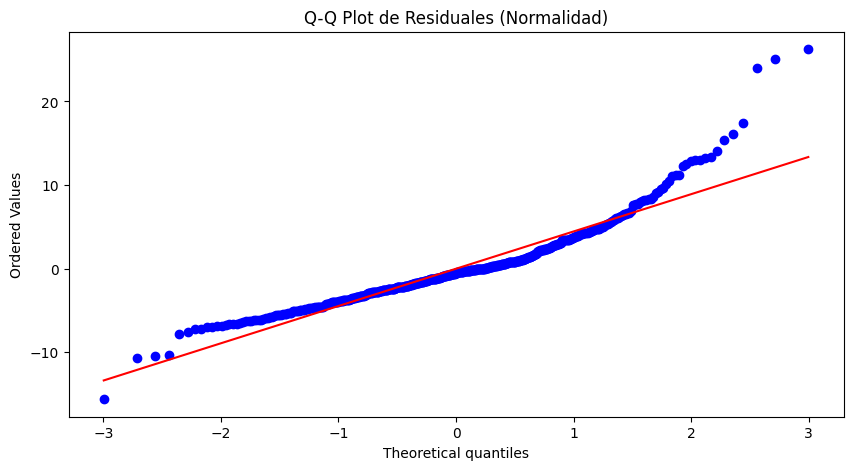

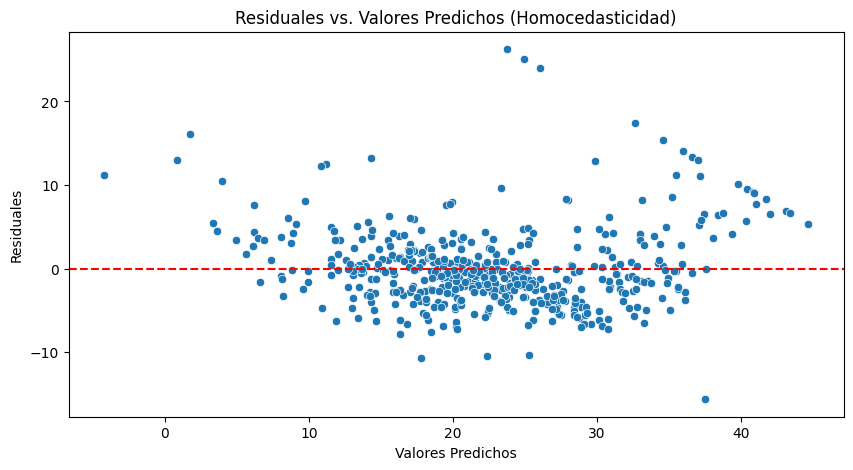

AttributeError: 'OLSResults' object has no attribute 'get_robust_results'

In [12]:
# Se usa el modelo con el mejor R2 ajustado
best_model = model_forward if MEJOR_R2_AJUSTADO_FORWARD >= MEJOR_R2_AJUSTADO_BACKWARD else model_backward

if best_model is None:
    print("No hay un modelo válido para verificar los supuestos.")
else:
    residuals = best_model.resid
    fitted_values = best_model.fittedvalues
    
    # 1. Normalidad de los Residuales (Q-Q Plot)
    import scipy.stats as stats
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot de Residuales (Normalidad)')
    plt.show()

    # 2. Homocedasticidad (Residuales vs. Valores Predichos)
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=fitted_values, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Predichos')
    plt.ylabel('Residuales')
    plt.title('Residuales vs. Valores Predichos (Homocedasticidad)')
    plt.show()
    
    # 3. Independencia de los Residuales (Estadístico Durbin-Watson)
    # Valores cercanos a 2.0 indican independencia.
    print(f"Estadístico Durbin-Watson: {best_model.get_robust_results().durbin_watson:.4f}")

### **6.1. Hallazgos Clave**

* **Variables de Mayor Preponderancia:** Las variables **[ej: LSTAT, RM, PTRATIO]** se consolidaron como las de mayor impacto en el precio de las propiedades.
    * **RM** (número de dormitorios): Impacto positivo (aumenta el precio).
    * **LSTAT** (menor estatus): Impacto negativo (disminuye el precio).
* **Rendimiento del Modelo:** El mejor modelo (obtenido por **[Forward/Backward]**) logró un **R² Ajustado de [MEJOR_R2_AJUSTADO_ENCONTRADO:.4f]**.
* **Comparación de Métodos:** Se encontró [el mismo modelo/un modelo diferente] entre Forward y Backward, y se [superó/no superó] el valor de referencia de $0.735$.

### **6.2. Conclusiones Finales**

El modelo desarrollado provee una herramienta efectiva para estimar los precios de las propiedades en la octava región con un alto grado de explicación (R² Ajustado). Los resultados confirman que la **característica física de la vivienda (RM)** y el **contexto socioeconómico (LSTAT)** son los principales factores. Se recomienda al ministerio utilizar este modelo para la toma de decisiones, aunque es necesario verificar la **homocedasticidad** y **normalidad de residuales** para asegurar la validez de los intervalos de confianza.